# Measurement errors

### Query trace from DB and preprocess it

In [1]:
import pandas as pd
import sqlite3

def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by the db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)

    return conn

conn = create_connection(r'C:\Users\rouma\Documents\BlueRock\TraceDB.db')
cur = conn.cursor()

df = pd.read_sql_query(''' Select * from Trace_A17501 Where TraceID == '5174539_1' ''', conn)
df['gpsAt'] = pd.to_datetime(df['gpsAt'])
df['gpsAt'] = df['gpsAt'].dt.tz_localize(None)
df


,alt,batPct,gpsAt,heading,lat,lon,speed,DeviceName,TraceID,DistanceFromArrival
0,0,92,2021-11-11 07:39:14,82,49.1934,-123.1478,57,A10165,5174539_1,257.779110
1,-7,93,2021-11-11 07:39:55,108,49.1923,-123.1388,59,A10165,5174539_1,257.360461
2,-14,92,2021-11-11 07:40:37,84,49.1910,-123.1307,3,A10165,5174539_1,257.006922
3,12,93,2021-11-11 07:42:08,84,49.1909,-123.1256,28,A10165,5174539_1,256.732749
4,-9,92,2021-11-11 07:43:14,88,49.1909,-123.1217,58,A10165,5174539_1,256.517698
...,...,...,...,...,...,...,...,...,...,...
1025,525,100,2021-11-11 13:08:33,188,50.6631,-120.3560,26,A10165,5174539_1,0.358940
1026,535,100,2021-11-11 13:08:40,230,50.6626,-120.3565,38,A10165,5174539_1,0.308275
1027,545,100,2021-11-11 13:08:46,244,50.6623,-120.3572,40,A10165,5174539_1,0.253072
1028,529,100,2021-11-11 13:09:55,260,50.6616,-120.3597,0,A10165,5174539_1,0.081485


## Calculate distance, avg. speed and compare to given speed.

SpeedDiff negative: Calculated speed higher than recorded speed: Driver was faster than recorded. Possibly, the GPS device did not send any information even though the truck drove according to the next GPS lat-lon coordinates. <br/>
SpeedDiff positive: Recorded speed higher than calculated speed. GPS device recorded speeds that are too high.

In [2]:
from math import cos, asin, sqrt, pi
from datetime import datetime

def distanceInKm(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742 * asin(sqrt(a))

def distanceInKm1(latDiff, lonDiff, lat1, lat2):
    p = pi/180
    a =  0.5 - cos((latDiff)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lonDiff)*p))/2
    return 12742*asin(sqrt(a))

def timeInSecs(t1, t2):
    try:
        #time1 = datetime.strptime(t1,'%Y-%m-%dT%H:%M:%S%z')
        #time2 = datetime.strptime(t2,'%Y-%m-%dT%H:%M:%S%z')
        secDifference = (t2-t1).total_seconds()
    except: 
        
        return 0
    return secDifference


def getCalculatedSpeedAndDifference(df):
    distances = [distanceInKm(lat1, lat2, lon1, lon2) for lat1, lat2, lon1, lon2 in zip(df['lat'], df['lon'], df['lat'].shift(1),  df['lon'].shift(1))]
    time = [timeInSecs(t1, t2) for t1, t2 in zip(df['gpsAt'].shift(1), df['gpsAt'])]
    time
    timeInHour = [x / (60*60) for x in time]


    avgSpeed = []
    for i in range(len(time)):
        try:
            avgSpeed.append(distances[i] / timeInHour[i])
        except:
            avgSpeed.append(np.nan)
            
    df['avgSpeed'] = avgSpeed
    # Calculate the difference between the recorded and the calculated speed
    df['speedDiff'] = df['speed'] - df['avgSpeed']

### Visualization of speed differences over time. 
Above the red line: Positive speed difference. <br/>
Below the red line: Negative speed difference, possible that the GPS device did not send coordinates for some time.

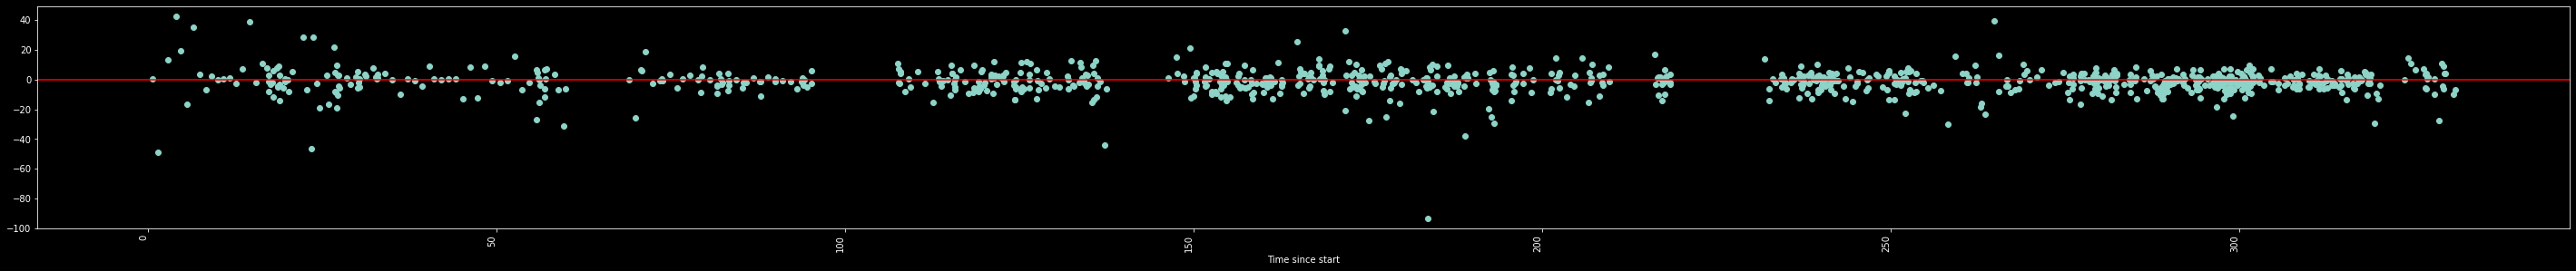

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from matplotlib import style
style.use('dark_background')

minDiff = [(t2 - df['gpsAt'][0]).total_seconds() / 60 for t2 in df['gpsAt']]
df['minDiff'] = minDiff
getCalculatedSpeedAndDifference(df)

fig, ax = plt.subplots(1)
fig.autofmt_xdate()

plt.xticks(rotation=90)
plt.scatter(df['minDiff'], df['speedDiff'])
plt.axhline(y=0, color ='r', linestyle='-')

xfmt = mdates.DateFormatter('%d-%m-%y %H:%M')
#ax.xaxis.set_major_formatter(xfmt)
plt.xlabel('Time since start')
plt.rcParams["figure.figsize"] = (50,5)
#figure(figsize=(8, 6), dpi=80)
#plt.xlim(startDt, endDt )
plt.savefig('Plot.png')

Classify if the differences in the speed are large or not. We mark differences in speed of over 10 km/h.  

In [10]:
def classifySpeedDifferences(df):
    timeBetweenRecordings = [(time2 - time1)  for time1, time2 in zip(df['minDiff'].shift(1), df['minDiff'])]
    df['TimeBetweenRecordings']= timeBetweenRecordings
    df.loc[df['speedDiff'] < -10, 'LargeDifference'] = 'Negative Difference'
    df.loc[df['speedDiff'] > 10, 'LargeDifference'] = 'Positive Difference'
    df.loc[((df['speedDiff'] > -10) & (df['speedDiff'] < 10)), 'LargeDifference'] = 'No Difference'
#df[['minDiff', 'TimeBetweenRecordings', 'speed', 'avgSpeed', 'speedDiff', 'LargeDifference']]


Method goes over all the recordings and takes note of recordings and sequences of recordings with high positive or negative speed differences. If these periods of high speed differences go on for more than 15 minutes, we conclude that there is a measurement error in the trace.

In [12]:
def getMeasurementErrors(df):
    listSubsequentDifferences = []
    listOfSubsequentIndices = []
    countMinutes = 0
    noOfMeasurementErrors = 0

    listOfMeasurementErrors = []
    for i in df[['LargeDifference', 'TimeBetweenRecordings']].itertuples():
        #print(i[1:3])

        # If the current difference is unequal to the last type of difference in the list, the subsequent recordings do not both have the same difference.
        # Therefore, we assume that it is not a large-scale measurement error and flush the list.
        if len(listSubsequentDifferences) > 0:
            if i[1] != listSubsequentDifferences[-1]:
                listSubsequentDifferences = []
                listOfSubsequentIndices = []
                countMinutes = 0

        # If there is a positive or a negative difference in the recording, we note it down in the lists. 
        # We also sum up the duration of the recording. If subsequent recordings with differences are in total more than 15 minutes, we classify the trace as having a measurement error.
        if i[1] == 'Positive Difference':
            countMinutes = countMinutes + i[2]
            listSubsequentDifferences.append(i[1])
            listOfSubsequentIndices.append(i[0])

        if i[1] == 'Negative Difference':
            countMinutes = countMinutes + i[2]
            listSubsequentDifferences.append(i[1])
            listOfSubsequentIndices.append(i[0])

        if countMinutes > 15:
            noOfMeasurementErrors = noOfMeasurementErrors + 1
            listOfMeasurementErrors.append([listSubsequentDifferences,listOfSubsequentIndices])

    return [noOfMeasurementErrors, listOfMeasurementErrors]


# Whole process of getting measurement errors for a trace

In [16]:
# Method returns the number of measurement errors and their sequences 
def checkTraceForMeasurementErrors(df):
    minDiff = [(t2 - df['gpsAt'][0]).total_seconds() / 60 for t2 in df['gpsAt']]
    df['minDiff'] = minDiff

    getCalculatedSpeedAndDifference(df)
    classifySpeedDifferences(df)
    return getMeasurementErrors(df)
result = checkTraceForMeasurementErrors(df)
result[1]

# Method return true if there is a measurement error and false if not
def hasMeasurementError(df):
    minDiff = [(t2 - df['gpsAt'][0]).total_seconds() / 60 for t2 in df['gpsAt']]
    df['minDiff'] = minDiff

    getCalculatedSpeedAndDifference(df)
    classifySpeedDifferences(df)
    result = getMeasurementErrors(df)

    if len(result[1]) > 0:
        return True
    return False
hasMeasurementError(df)


False